# Data processing of plume simulation

In [1]:
#####Loading packages and basic functions#####
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

from decimal import Decimal

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = -2 #Maximal number of cores in use
extension = '.pdf' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
#DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

def v_to_s(v) :
    if v == 0 :
        return 'Inf'
    else :
        return '%.1E' % v

def v_to_d(v) :
    return '%.2f' % v
    
def v_to_pow(v) :
    if v == 0 :
        return 'Inf'
    else :
        power  = int(np.log10(v))
        factor = int(v/10.0**power)
        if factor == 1.0 :
            return r'$10^{'+str(power)+'}$'
        else :
            return str(factor)+r'$\times 10^{'+str(power)+'}$'

def print_keys(dict_) :
    for key in dict_ : print(key)
    return

In [2]:
#####Reference values and ranges for filename generation#####
UREF = 4.6E-06
TREF = 2.92E+01
PECLET    = [0,1e3,1e2,1e1]
D_DICT    = {0:'$x_1(t)$',1:'$x_2(t)$',2:'$x_3(t)$',3:'$l(t)$'}
POW_RANGE = [-3, -2, -1, 0, 1, 2]
T_SNAP    = [1.0*10**n_ for n_ in POW_RANGE] + [2.0*10**n_ for n_ in POW_RANGE[:-1]] + [5.0*10**n_ for n_ in POW_RANGE[:-1]]
T_SNAP.sort()
N_SNAP = len(T_SNAP)

FNAMES = {}
for Pe_ in PECLET :
    subdir_ = 'Bentheimer1000/Plumes_mode2/Pe'+v_to_s(Pe_)+'/'
    FNAMES[Pe_] = {t_ : DIR + subdir_ + 'Pe' + v_to_s(Pe_) + '_T'+ v_to_s(t_) + '.txt' for t_ in T_SNAP}

print('Peclet values')
print(PECLET)
print('Filenames')
for Pe_ in PECLET :
    for t_ in T_SNAP :
        print(FNAMES[Pe_][t_])

Peclet values
[0, 1000.0, 100.0, 10.0]
Filenames
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T1.0E-03.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T2.0E-03.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T5.0E-03.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T1.0E-02.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T2.0E-02.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T5.0E-02.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T1.0E-01.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T2.0E-01.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T5.0E-01.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T1.0E+00.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T2.0E+00.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T5.0E+00.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T1.0E+01.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/PeInf/PeInf_T2.0E+01.txt
D:/pdm_data/Bentheimer1000/Plumes_mode2/P

In [3]:
#####Missing data file check, delete name of files that do not exist#####
MISSING = False
missing_keys_dms   = []
missing_keys_tsnaps = []
for Pe_ in FNAMES :
    for tsnap_ in FNAMES[Pe_] : 
        if not os.path.isfile(FNAMES[Pe_][tsnap_]) :
            MISSING = True
            print('Warning :')
            print('\t' + FNAMES[Pe_][tsnap_])
            print('not found')
            missing_keys_dms.append(Pe_)
            missing_keys_tsnaps.append(tsnap_)
for (Pe_,tsnap_) in zip(missing_keys_dms,missing_keys_tsnaps) :
    del FNAMES[Pe_][tsnap_]
if not MISSING :
    print ('All data have been found :)')

	D:/pdm_data/Bentheimer1000/Plumes_mode2/Pe1.0E+01/Pe1.0E+01_T1.0E+01.txt
not found
	D:/pdm_data/Bentheimer1000/Plumes_mode2/Pe1.0E+01/Pe1.0E+01_T2.0E+01.txt
not found
	D:/pdm_data/Bentheimer1000/Plumes_mode2/Pe1.0E+01/Pe1.0E+01_T5.0E+01.txt
not found


In [4]:
#####Loading the existing data#####
dataDNS = {}
print('loading file')
for Pe_ in FNAMES :
    print('\tPe = ' + v_to_s(Pe_))
    dataDNS[Pe_] = {}
    print('\t\t(Tsnap, Np) =', end = ' ')
    for tsnap_ in FNAMES[Pe_] :
        dataDNS[Pe_][tsnap_] = np.loadtxt(open(FNAMES[Pe_][tsnap_], 'r').readlines()[:-1])
        N_P=len(dataDNS[Pe_][tsnap_][:,0])
        print('('+v_to_s(tsnap_)+', '+str(N_P+1)+')', end = ', ')
    print('')

loading file
	Pe = Inf
		(Tsnap, Np) = (1.0E-03, 140567), (2.0E-03, 140567), (5.0E-03, 140567), (1.0E-02, 140567), (2.0E-02, 140567), (5.0E-02, 140567), (1.0E-01, 140567), (2.0E-01, 140567), (5.0E-01, 140567), (1.0E+00, 140567), (2.0E+00, 140567), (5.0E+00, 140567), (1.0E+01, 140567), (2.0E+01, 140567), (5.0E+01, 140567), (1.0E+02, 140555), 
	Pe = 1.0E+03
		(Tsnap, Np) = (1.0E-03, 200000), (2.0E-03, 200000), (5.0E-03, 200000), (1.0E-02, 200000), (2.0E-02, 200000), (5.0E-02, 200000), (1.0E-01, 200000), (2.0E-01, 200000), (5.0E-01, 200000), (1.0E+00, 200000), (2.0E+00, 200000), (5.0E+00, 200000), (1.0E+01, 200000), (2.0E+01, 200000), (5.0E+01, 200000), (1.0E+02, 200000), 
	Pe = 1.0E+02
		(Tsnap, Np) = (1.0E-03, 200000), (2.0E-03, 200000), (5.0E-03, 200000), (1.0E-02, 200000), (2.0E-02, 200000), (5.0E-02, 200000), (1.0E-01, 200000), (2.0E-01, 200000), (5.0E-01, 200000), (1.0E+00, 200000), (2.0E+00, 200000), (5.0E+00, 200000), (1.0E+01, 200000), (2.0E+01, 200000), (5.0E+01, 200000), (1.0E+

In [5]:
#####Auxiliary functions to compute PDF and return mean and std#####
def Extract_pdf(data_, nbins = 500, returnNP = False, dst = True) :
    np_  = len(data_)
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    if returnNP :
        return pdf_, np_
    else :
        return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

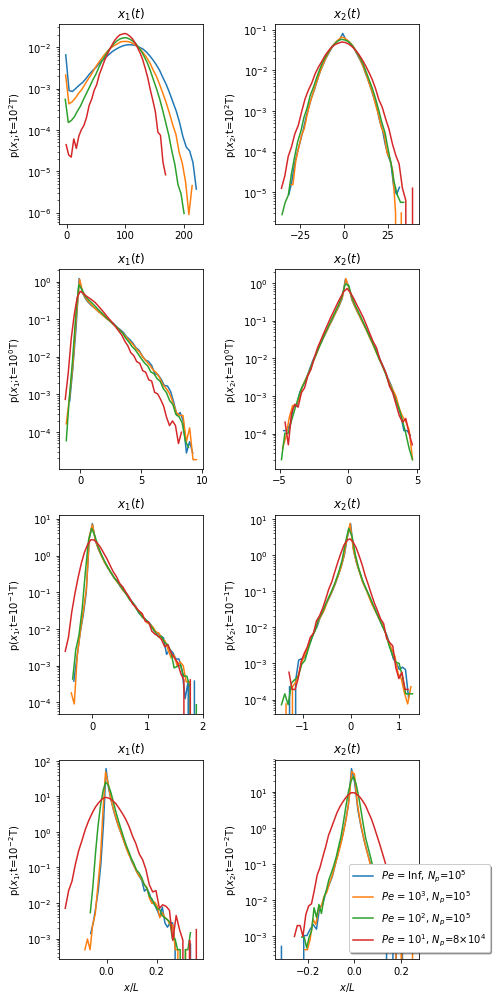

In [11]:
#####Evolution of the position PDF for various directions, Pe and times#####
T_PLOTS      = [1.0E+02, 1.0E0, 1.0E-1, 1.0E-2]
D_VALUES     = [0,1]
PECLET_PLOTS = [0.0, 1000.0, 100.0, 10.0]
fig, axs = plt.subplots(len(T_PLOTS),len(D_VALUES), figsize = (3.5*len(D_VALUES),3.5*len(T_PLOTS)))
c_  = 0
nbins_ = 40
plot_hist = False
for d_ in D_VALUES :#range(4) :
    dname_ = D_DICT[d_]
    l_ = 0
    for t_ in T_PLOTS :
        if len(D_VALUES) == 1 : ax = axs[l_]
        elif len(T_PLOTS) == 1 : ax = axs[c_]
        else : ax = axs[l_,c_]
        ci_ = 0
        for Pe_ in PECLET_PLOTS :
            if t_ in dataDNS[Pe_] :
                [x_, y_], N_P_  = Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_, True)
                ax.semilogy(x_, y_, color = color_cycle[ci_], label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_));
                ci_ += 1
            ax.set_ylabel(r'p($x_'+str(d_+1)+'$;t='+v_to_pow(t_)+'T)')
        ax.set_title(dname_)
        l_ += 1
    c_ += 1
    ax.set_xlabel('$x/L$')
ax.legend(loc='upper center', bbox_to_anchor=(1.0, 0.5), shadow=True, ncol=1)
plt.tight_layout()
plt.savefig(DIR+'Figures/early_plume_displacement_pdf'+extension)

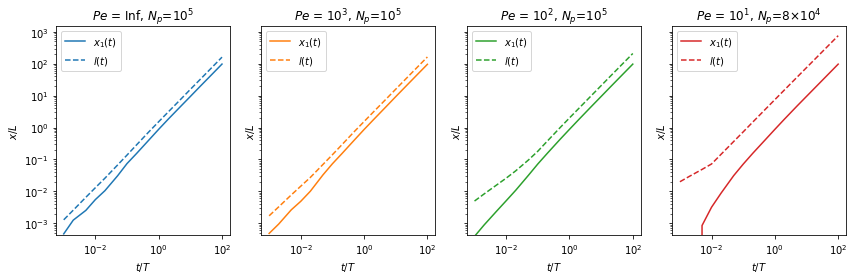

In [12]:
#####Plot of mean position for $x_1$ and total traveled distance#####
fig, axs = plt.subplots(1,len(PECLET), figsize = (12,4), sharey = True)
D_VALUES = [0,3]
d_ = 0
nbins_ = 40
c_ = 0
for i in range(len(PECLET)) :
    l_ = 0
    ax = axs[c_]
    for (d_,lst_) in zip(D_VALUES,['-','--']) :
            Pe_ = PECLET[i]; clr = color_cycle[i]
            TIME_ = np.array([tt_ for tt_ in dataDNS[Pe_]])
            PDF_ = [Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_) for t_ in dataDNS[Pe_]]
            MEAN_ = [Return_mean(pdf_) for pdf_ in PDF_]    
            N_P_ = len(dataDNS[Pe_][t_][:,0])
            ax.loglog(TIME_, MEAN_, linestyle = lst_, color = clr, label = D_DICT[d_])
    ax.set_title('$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_))
    ax.set_xlabel('$t/T$')
    ax.set_ylabel('$x/L$')
    ax.legend()
    c_ += 1
plt.tight_layout()
plt.savefig(DIR+'Figures/variance_x1_x2'+extension)

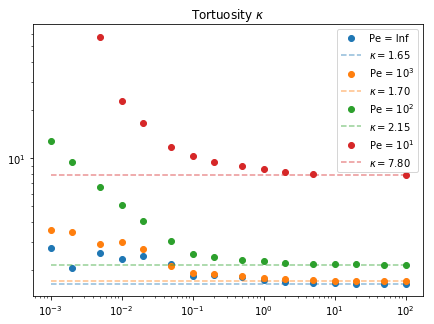

In [13]:
#####Retrieving tortuosity from mean l(t) and x1(t)#####
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.set_title('Tortuosity $\kappa$')
ci_ = 0
for Pe_ in PECLET :
    clr_ = color_cycle[ci_]
    TIME_        = np.array([tt_ for tt_ in dataDNS[Pe_]])
    PDF_x1       = [Extract_pdf(dataDNS[Pe_][t_][:,0], nbins_) for t_ in dataDNS[Pe_]]
    MEAN_x1      = [Return_mean(pdf_) for pdf_ in PDF_x1]
    
    PDF_l        = [Extract_pdf(dataDNS[Pe_][t_][:,3], nbins_) for t_ in dataDNS[Pe_]]
    MEAN_l       = [Return_mean(pdf_) for pdf_ in PDF_l]
    KAPPA        = [ml_ / mx_ for ml_, mx_ in zip(MEAN_l, MEAN_x1)]
    x_           = TIME_
    y_           = KAPPA
    ax.loglog(x_, y_,'o', label = 'Pe = '+v_to_pow(Pe_), color = clr_)
    
    kappa_end = (KAPPA[-1])
    y_ = [kappa_end for xx_ in x_]
    ax.plot(x_, y_,'--', alpha = 0.5, label = '$\kappa =$'+v_to_d(kappa_end), color = clr_)
    
    ci_ += 1
ax.legend();

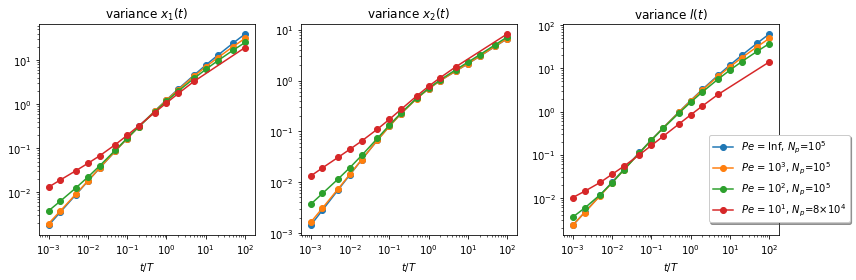

In [14]:
#####Plot of variance#####
fig, axs = plt.subplots(1,3, figsize = (12,4))
d_ = 0
nbins_ = 100
ci_ = 0
for d_ in [0, 1, 3] :
    ax = axs[ci_]
    for Pe_ in PECLET :
            PDF_ = [Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_) for t_ in dataDNS[Pe_]]
            STD_ = [Return_std(pdf_) for pdf_ in PDF_]    
            N_P_ = len(dataDNS[Pe_][t_][:,0])
            ax.loglog([tt_ for tt_ in dataDNS[Pe_]],STD_, 'o-', label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_))
    ax.set_title('variance $x_'+str(d_+1)+'(t)$')
    ax.set_xlabel('$t/T$')
    ci_ += 1
ax.set_title('variance $l(t)$')
ax.legend(loc='upper center', bbox_to_anchor=(1.0, 0.5), shadow=True, ncol=1)
plt.tight_layout()
plt.savefig(DIR+'Figures/variance_x1_x2'+extension)

Possible thumb rules : 
$$ \lim_{Pe\rightarrow \infty} \sigma \approx \mu $$
$$ \lim_{Pe\rightarrow 0} \sigma \approx \textrm{const} $$

In [15]:
#####Counting the number of particles with negative position#####
def count_backflow (snapshot, density = True) :
    x_ = snapshot[:,0]
    N_tot  = len(x_)
    N_back = np.sum(x_ < 0.0)
    if density :
        return 1.0*N_back/N_tot
    else :
        return N_back

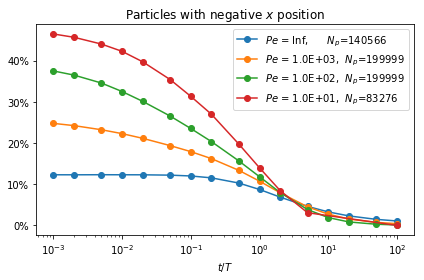

In [16]:
#####Plot of backflow#####
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(1,1, figsize = (6,4))

for Pe_ in PECLET :
    x_    = [tt_ for tt_ in dataDNS[Pe_]]
    y_    = [count_backflow(dataDNS[Pe_][t_]) for t_ in x_]
    N_P_  = len(dataDNS[Pe_][t_][:,0])
    ax.semilogx(x_, y_, 'o-', label = '$Pe$ = '+v_to_s(Pe_) + ',\t $N_p$='+str(N_P_))
ax.set_title('Particles with negative $x$ position')
ax.set_xlabel('$t/T$')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend()
plt.tight_layout()
plt.savefig(DIR+'Figures/backflow'+extension)

## Markov model 

In [17]:
#####Model parameter set#####
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

In [18]:
#####Tools for stochastic process#####
from scipy.stats import rv_continuous
#Diffusion function from DWM
def d(v,sample) :
    b = sample['b']
    c = sample['c']
    return c*np.exp(b*v)

#Drift function from DWM
def a(v,sample) :
    eps  = 0.1
    p_p1 = p_skew(v+eps,sample); p_m1 = p_skew(v-eps,sample);
    d_p1 = d(v+eps,sample);      d_m1 = d(v-eps,sample);
    d_   = d(v,sample);
    grad = (np.log(p_p1 * d_p1)-np.log(p_m1 * d_m1))/(2.0*eps)
    return d_/2.0 * grad

#Skew-normal PDF
def p_skew(v,sample = Bentheimer1000) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

class pskew_rv(rv_continuous):
    sample = {}
    def _pdf(self, x): return p_skew(x)       

def a_t (zt, yt, sample = Bentheimer1000) :
    omegat = sample['omegat']
    taut = sample['taut']
    return (omegat**2 * zt + yt / taut)   

def d_t (sample = Bentheimer1000) :
    bt   = sample['mut']
    taut = sample['taut']
    return bt**2 * 2.0/taut
    
def f_theta (zt, sample = Bentheimer1000) :
    omegat = sample['omegat']
    sigmat = sample['sigmat']
    epsilon = 1e-12
    return sigmat*np.sqrt(np.log((2.0+epsilon)**2) - 2.0*np.log((1-np.erf(omegat*zt/np.sqrt(2)))+epsilon))

#Log velocity magnitude model from Meyer and Bijeljic 2016
def Plume_process(sample, param):
    if param['seed'] is not None : 
        rdm.seed(param['seed'])
    else :
        rdm.seed()

    dt    = param['dt']
    Tsnap = param['Tsnap']
    Np    = param['Np']
    Nsnap = len(Tsnap)
    delta = dt #Wiener process
    x_snapshots = {}
    l_snapshots = {}

    #Selecting a random initial velocity from skew normal pdf
    snd = pskew_rv(name='snd')
    snd.sample = Bentheimer1000
    v0      = snd.rvs(size=Np)
    ##
    
    #Initialization
    t_    = 0.0 #Time

    v_    = v0 #Log velocity magnitude
    
    theta_= np.zeros(Np) #Directional angle
    zt_   = np.zeros(Np, dtype=np.float64) #
    yt_   = np.zeros(Np)
    
    x_    = np.zeros(Np) #x1 position
    l_    = np.zeros(Np) #Traveled length
    
    c_    = 0
    
    #Temporal loop
    while t_ <= Tsnap[-1] :
        #Snapshot
        if (Tsnap[c_] - t_ < dt ) :
            x_snapshots[Tsnap[c_]] = [xx_ for xx_ in x_]
            l_snapshots[Tsnap[c_]] = [ll_ for ll_ in l_]
            c_ += 1        
        #LVM process
        dW_ = rdm.normal(loc=0.0, scale=np.sqrt(dt), size=None)
        dv  = a(v_,sample)*dt + np.sqrt(d(v_,sample))*dW_
        v_ += dv
        #Theta angle process
        dl_  = np.exp(v_) * dt
        dW_ = rdm.normal(loc=0.0, scale=np.sqrt(dl_), size=None)
        yt_ += -a_t(zt_, yt_, sample)*dl_ + np.sqrt(d_t(sample))*dW_
        zt_ += yt_ * dl_
        theta_ = f_theta(zt_, sample)
        #Position update
        x_  += np.exp(v_) * np.cos(theta_) * dt
        l_  += np.exp(v_) * dt
        #Time update
        t_  += dt
    return x_snapshots, l_snapshots

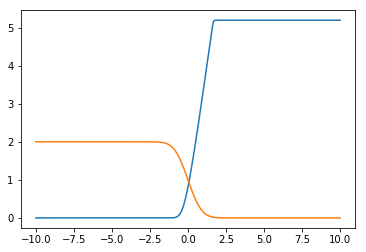

In [19]:
#####Note on the modification used to regularize f_theta function#####
x = np.linspace(-10,10,500)
x.astype(np.float64)
plt.plot(x, f_theta(x))
#plt.plot(x, np.sqrt(np.log((2.0+1e-12)**2) - 2.0*np.log((1-np.erf(x))+1e-12)))
plt.plot(x,1-np.erf(x))

Changed $\sqrt{\ln(4) - 2\ln(\textrm{erfc}(x))}$ to  $\sqrt{\ln((2+\epsilon)^2) - 2\ln(\textrm{erfc}(x) + \epsilon)}$ to avoid nan results

In [20]:
#####Auxiliary functions to save and load process results as dictionnaries#####
def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename, float_keys = False) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    #Retrieving keys as float
    if float_keys :
        tmp = {}
        tmp = {float(key) : MP_dict[key] for key in MP_dict}
        return tmp
    return MP_dict

In [21]:
#####Run of the Markov model or load previous results#####
Xfname = 'D:/pdm_data/Processed_data/Markov_plume_X_Np2E5_PeInf'
Lfname = 'D:/pdm_data/Processed_data/Markov_plume_L_Np2E5_PeInf'
Tsnap     = [0.01, 0.1, 1.0, 10.0, 100.0]
Nptot     = 2e5
Np_thread = 500
Nthreads  = int(Nptot/Np_thread)
MP_params = {
'seed' : None,
'dt'   : 1e-3,
'Tsnap': Tsnap,
'Np'   : Np_thread
}
RERUN  = False
NCORES = -1
if os.path.isfile(Xfname) and os.path.isfile(Lfname) and not RERUN:
    Xsnap = Load_data(Xfname, True)
    Lsnap = Load_data(Lfname, True)
elif RERUN :
    start = time.time()
    results  = Parallel(n_jobs=NCORES)(delayed(Plume_process)(Bentheimer1000, MP_params) for n_ in range(Nthreads))
    stop = time.time()
    print('Time needed : ' + str(stop - start))
    Xsnap = {}; Lsnap = {}
    for tt_ in Tsnap :
        X_ = [];  L_ = []
        for n_ in range(Nthreads) :
            X_ += results[n_][0][tt_]
            L_ += results[n_][1][tt_]
        Xsnap[tt_] = X_
        Lsnap[tt_] = L_
    del results  
    Save_data(Xsnap, Xfname)
    Save_data(Xsnap, Lfname)
else : print('Processed data not found.')

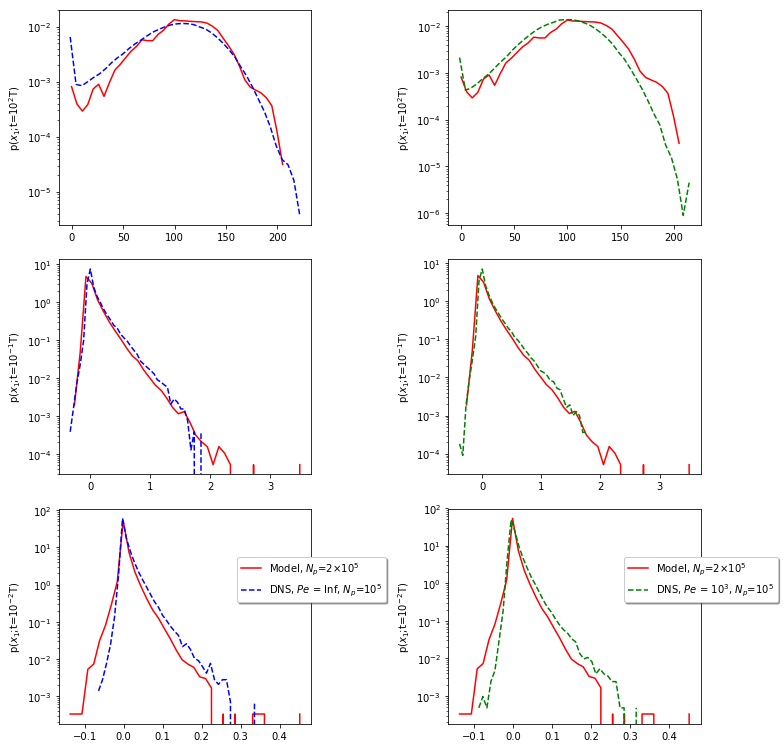

In [23]:
#####Comparison between Markov process and DNS data for Pe = Inf#####
T_PLOTS  = [100, 0.1, 0.01] #Tsnap[::-1]
PE_PLOTS = [0, 1000]
fig, axs = plt.subplots(len(T_PLOTS),len(PE_PLOTS), figsize = (5.5*len(PE_PLOTS),3.5*len(T_PLOTS)))
c_ = 0
for (Pe_, ci_) in zip(PE_PLOTS,['b','g']) :
    l_ = 0
    d_ = 0
    nbins_ = 40
    for t_ in T_PLOTS :
        if len(PECLET) == 1 : ax = axs[l_]
        elif len(T_PLOTS) == 1 : ax = axs[c_]
        else : ax = axs[l_,c_]
        [x_, y_], N_P_ = Extract_pdf(Xsnap[t_], nbins_, True)
        ax.semilogy(x_, y_,  '-r', label = 'Model, $N_p$='+v_to_pow(N_P_))
        
        [x_, y_], N_P_  = Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_, True)
        ax.semilogy(x_, y_, '--'+ci_, label = 'DNS, $Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_));
    
        ax.set_ylabel(r'p($x_'+str(d_+1)+'$;t='+v_to_pow(t_)+'T)')
        l_ += 1
    ax.legend(loc='upper center', bbox_to_anchor=(1.0, 0.8), shadow=True, ncol=1);
    c_ += 1
plt.tight_layout()
plt.savefig(DIR+'Figures/Plume_vs_markov_Pe'+extension)